Subtype I: chi2 = 0.0232, p-value = 0.879
Subtype II: chi2 = 0.0778, p-value = 0.780


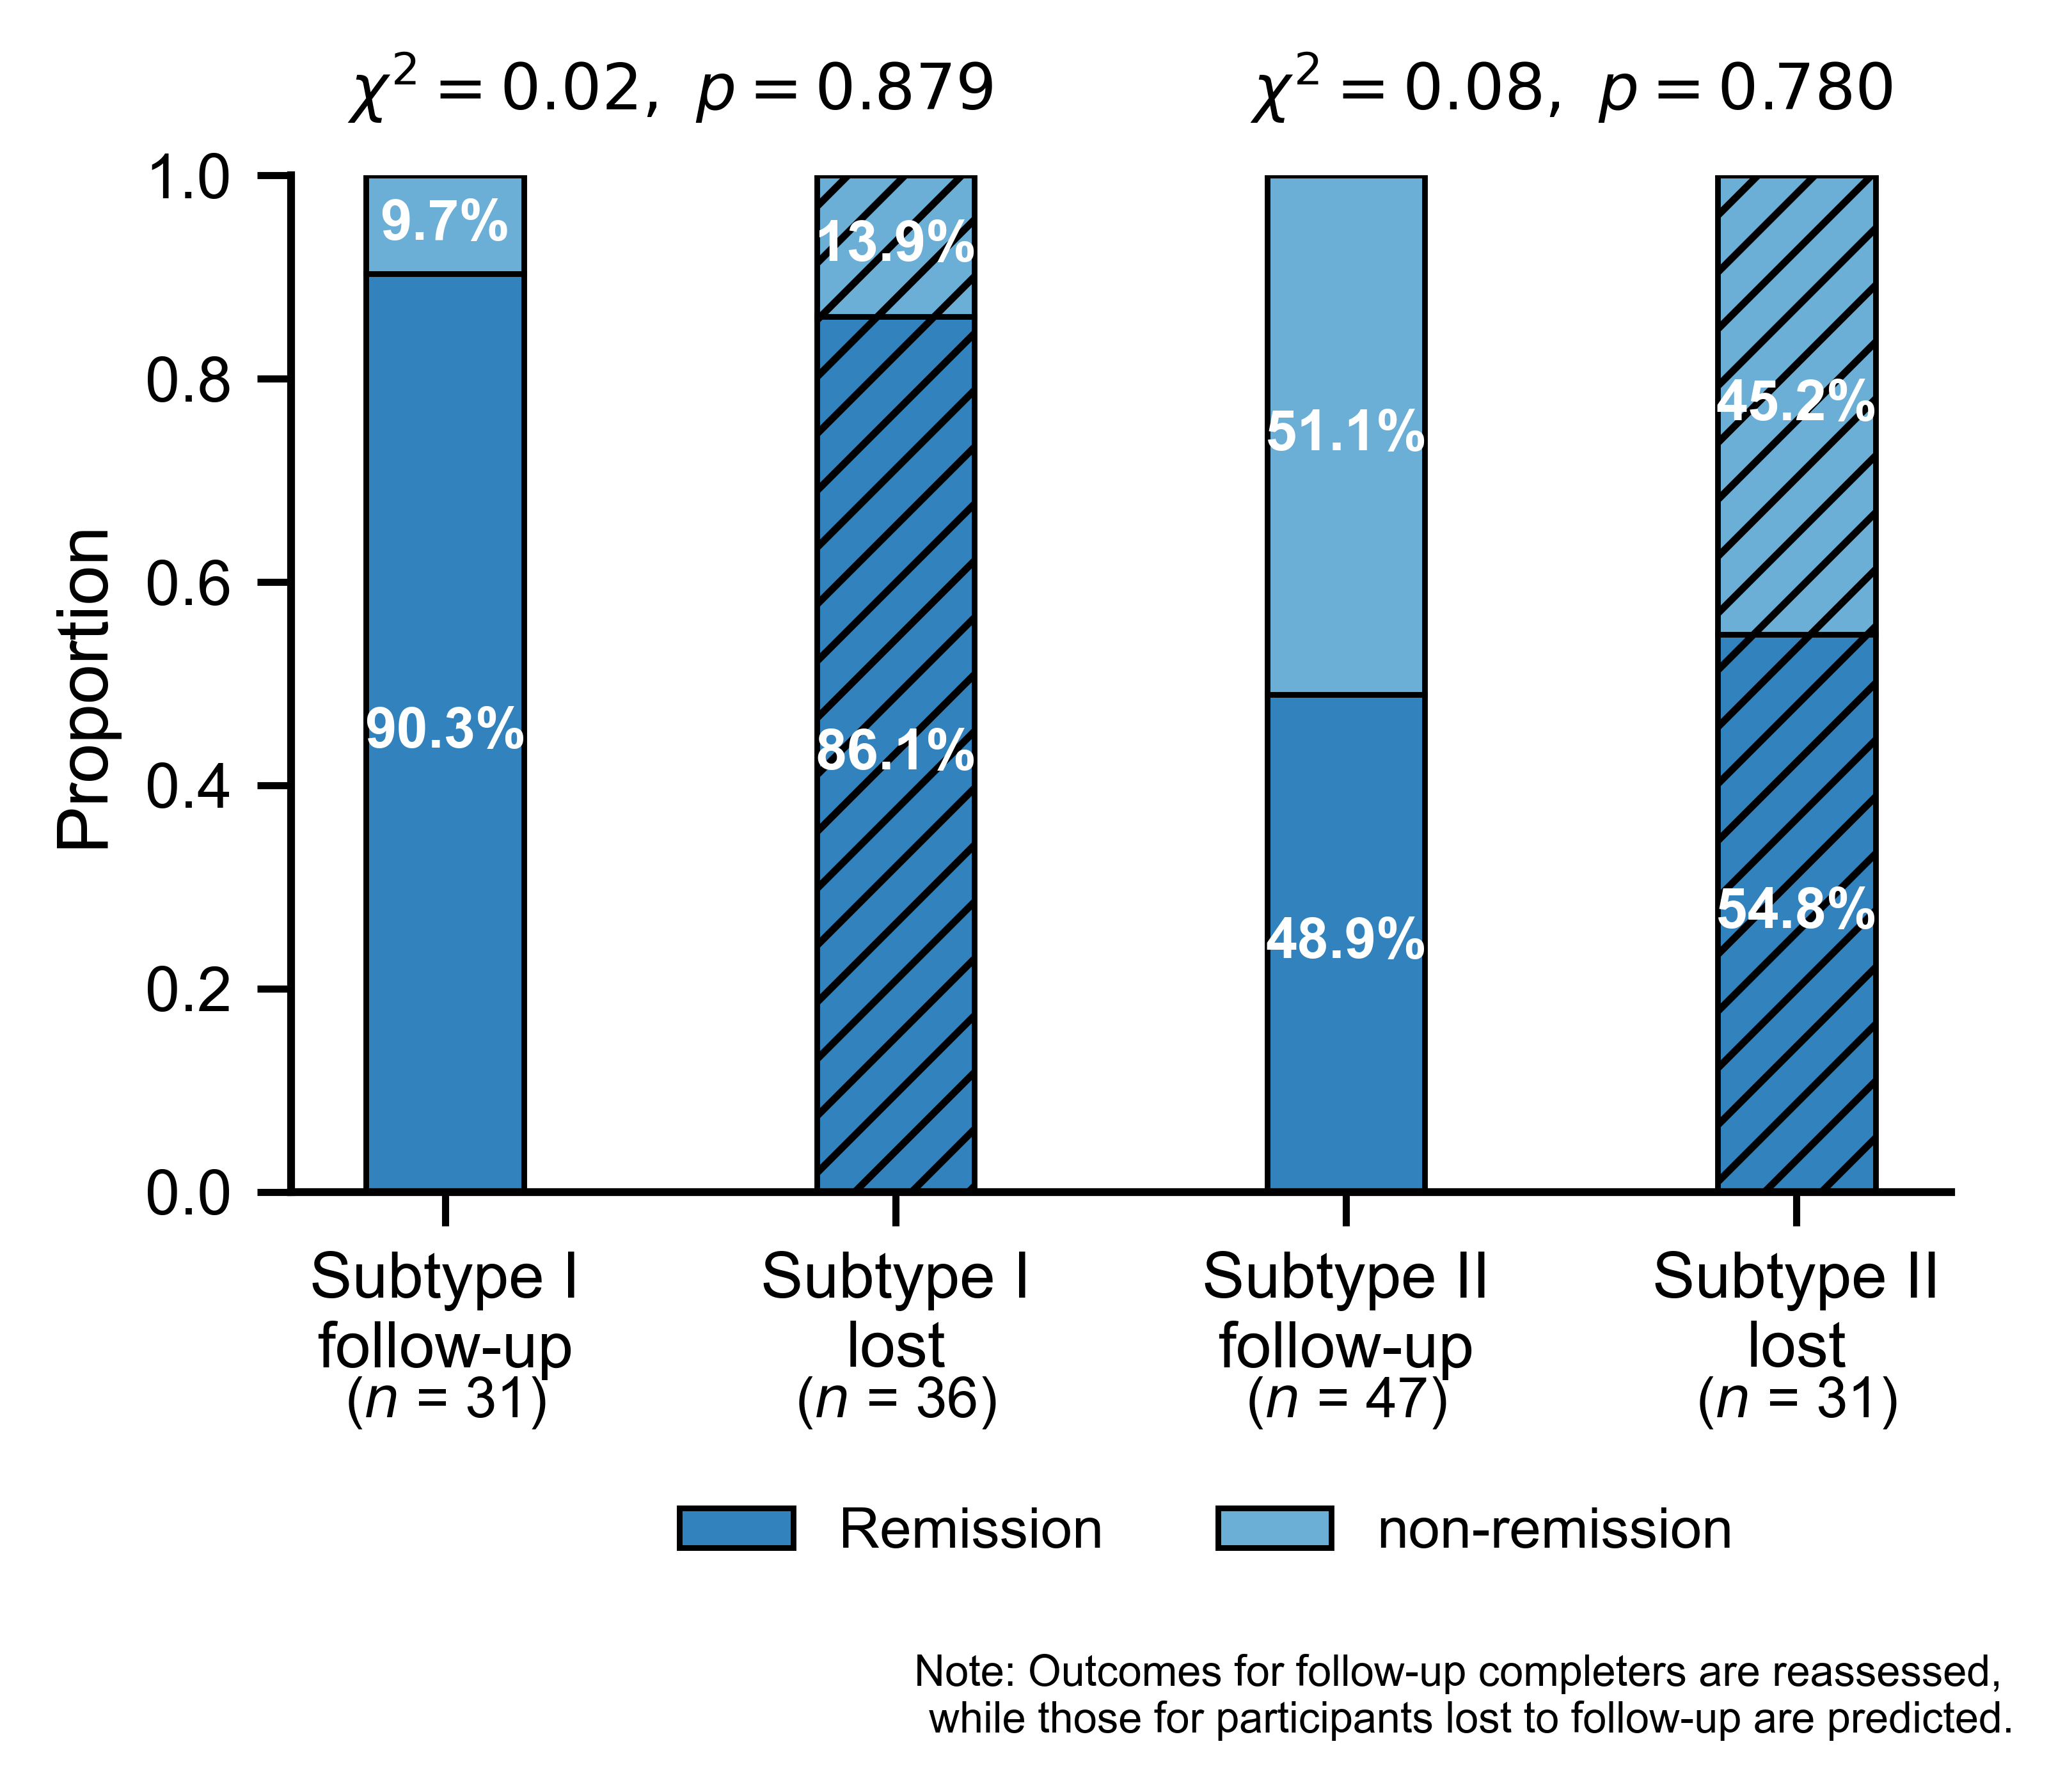

In [1]:
# -*- coding: utf-8 -*-

# -----------------------------------------------------------------------------#
# 0. 基础设置                                                                   #
# -----------------------------------------------------------------------------#
import warnings
from pathlib import Path
import pickle
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.base import InconsistentVersionWarning
from sklearn.ensemble import StackingClassifier

warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# -----------------------------------------------------------------------------#
# 1. 可调节参数                                                                 #
# -----------------------------------------------------------------------------#
# —— Nature 样式相关 —— #
STYLE_KW = dict(
    font_scale=1,          # sns context 缩放
    font_family="Arial",   # 字体
    axes_linewidth=1.1,    # 坐标轴线宽
    dpi=800,               # 保存 & 显示分辨率
)

# —— 颜色 —— #
PALETTE = {
    "Remission":     "#3182bd",
    "non-remission": "#6baed6",
}

# —— 图形尺寸 & 布局 —— #
FIGSIZE: Tuple[float, float] = (4.0, 3.5)   # (宽, 高) inch
BAR_WIDTH: float = 0.35

# —— 文字大小 —— #
FONTSIZE_YLABEL: int = 10
FONTSIZE_XTICK:  int = 9
FONTSIZE_PCT:    int = 8
FONTSIZE_N:      int = 8
FONTSIZE_PVAL:   int = 9
FONTSIZE_LEG:    int = 8
FONTSIZE_LEG_T:  int = 9
FONTSIZE_NOTE:   int = 6

# —— 注释位置 —— #
OFFSET_N:    float = -0.18   # n = ? 处于柱底下的偏移
OFFSET_PVAL: float = 0.03    # p 值文本距离柱顶的偏移（绝对坐标）
OFFSET_PCT:  float = 0.00    # 百分比文本相对柱中心的纵向偏移 (比例)

# —— 输出文件名 —— #
OUT_PNG = "remission_composition_Nature_4bars.jpg"

# —— Note 文本 —— #
NOTE_TEXT = (
    "Note: Outcomes for follow-up completers are reassessed, \n"
    "while those for participants lost to follow-up are predicted."
)

# -----------------------------------------------------------------------------#
# 2. 工具函数                                                                   #
# -----------------------------------------------------------------------------#
def set_nature_style(**kwargs) -> None:
    """Apply Nature-like plotting style. 关键字参数会覆盖默认值。"""
    cfg = {**STYLE_KW, **kwargs}
    sns.set_context("paper", font_scale=cfg["font_scale"])
    plt.rcParams.update({
        "font.family":        cfg["font_family"],
        "axes.linewidth":     cfg["axes_linewidth"],
        "axes.edgecolor":     "black",
        "axes.spines.top":    False,
        "axes.spines.right":  False,
        "xtick.direction":    "out",
        "ytick.direction":    "out",
        "xtick.major.width":  1.0,
        "ytick.major.width":  1.0,
        "legend.frameon":     False,
        "figure.dpi":         cfg["dpi"],
        "savefig.dpi":        cfg["dpi"],
    })


def draw_four_stackbars(
    ax: plt.Axes,
    df_cmp: pd.DataFrame,
    palette: Dict[str, str],
    pvals: Dict[str, Tuple[float, float]],
    *,
    bar_width: float       = BAR_WIDTH,
    pct_fontsize: int      = FONTSIZE_PCT,
    pct_color: str         = "white",
    pct_fontweight: str    = "bold",
    pct_offset: float      = OFFSET_PCT,
    n_offset: float        = OFFSET_N,
    pval_offset: float     = OFFSET_PVAL,
    xtick_fontsize: int    = FONTSIZE_XTICK,
    ylabel_fontsize: int   = FONTSIZE_YLABEL,
) -> None:
    """在单一坐标轴上绘制 4 根堆叠柱（I-F, I-L, II-F, II-L），lost-to-follow-up 柱添加 “///” 纹理，并标注具体 χ² 和 p 值。"""
    # —— 排序 —— #
    order = [("Subtype I", "followup"),
             ("Subtype I", "lost"),
             ("Subtype II", "followup"),
             ("Subtype II", "lost")]

    x_pos = np.arange(len(order))
    bottoms = np.zeros(len(order))

    # —— 透视表 & 计数 —— #
    pivot = (df_cmp
             .pivot_table(index=["Label", "source"],
                          columns="Group",
                          values="proportion",
                          fill_value=0.0)
             .reindex(order))
    counts = (df_cmp
              .groupby(["Label", "source"])["count"]
              .sum()
              .reindex(order))

    # —— 堆叠柱 —— #
    for outcome in ["Remission", "non-remission"]:
        heights = pivot[outcome].values
        bars = ax.bar(
            x_pos, heights,
            bottom=bottoms,
            color=palette[outcome],
            edgecolor="black",
            width=bar_width,
            label=outcome
        )
        # —— lost 栏添加纹理 —— #
        for idx, bar in enumerate(bars):
            if order[idx][1] == "lost":
                bar.set_hatch("///")

        # —— 添加百分比文本 —— #
        for bar, h in zip(bars, heights):
            if h > 1e-6:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + h / 2 + pct_offset,
                    f"{h * 100:.1f}%",
                    ha="center", va="center",
                    fontsize=pct_fontsize,
                    color=pct_color, fontweight=pct_fontweight
                )
        bottoms += heights

    # —— 轴标签 & 范围 —— #
    ax.set_xticks(x_pos)
    ax.set_xticklabels(["Subtype I\nfollow-up", "Subtype I\nlost",
                        "Subtype II\nfollow-up", "Subtype II\nlost"],
                       fontsize=xtick_fontsize)
    ax.set_ylabel("Proportion", fontsize=ylabel_fontsize)
    ax.set_ylim(0, 1)

    # —— n = ? —— #
    for x, total in zip(x_pos, counts):
        ax.text(x, n_offset, f"($n$ = {total})",
                ha="center", va="top", fontsize=FONTSIZE_N)

    # —— χ² 和 p 值标注 —— #
    # 在每个 subtype 的两根柱子中间位置标注具体统计量
    # pair_centres: subtype 对应的 x 起点
    pair_centres = {0: "Subtype I", 2: "Subtype II"}
    for x_start, subtype in pair_centres.items():
        chi2, p_val = pvals[subtype]
        ax.text(
            x_start + 0.5, 1.02 + pval_offset,
            f"$\\chi^2={chi2:.2f},\\ p={p_val:.3f}$",
            ha="center", va="bottom", fontsize=FONTSIZE_PVAL
        )

    # —— 图例 —— #
    ax.legend(
        fontsize=FONTSIZE_LEG,
        title_fontsize=FONTSIZE_LEG_T,
        loc="upper right",
        bbox_to_anchor=(0.90, -0.26),
        ncol=2
    )


def main() -> None:
    # —— 样式 —— #
    set_nature_style()

    # —— 读取模型 —— #
    with open("model_history_holdout/Stacking_9.pkl", "rb") as f:
        model_obj = pickle.load(f)
    stacking_model: StackingClassifier = (
        model_obj["clf"] if isinstance(model_obj, dict) and "clf" in model_obj else model_obj
    )

    # —— 映射 —— #
    label_map = {0: "Subtype I", 1: "Subtype II"}
    group_map = {1: "non-remission", 0: "Remission"}

    # ------------------------------------------------------------------ #
    # 3.1 已随访患者 (observed)                                           #
    # ------------------------------------------------------------------ #
    df_traced = (pd.read_excel("P0022023-study2.xlsx", sheet_name="Sheet1")
                   .query("Label in [0, 1]"))
    actual = (df_traced
              .groupby(["Label", "Group"])
              .size()
              .reset_index(name="count"))
    actual["proportion"] = actual.groupby("Label")["count"].transform(lambda x: x / x.sum())
    actual["Label"]  = actual["Label"].map(label_map)
    actual["Group"]  = actual["Group"].map(group_map)
    actual["source"] = "followup"
    actual["value_type"] = "true"

    # ------------------------------------------------------------------ #
    # 3.2 流失患者 (predicted)                                           #
    # ------------------------------------------------------------------ #
    df_lost = (pd.read_excel("P0022023-study2.xlsx", sheet_name="Sheet2")
                 .query("Label in [0, 1]")
                 .rename(columns={
                     "Cluster 1": "Subtype I Baseline",
                     "Cluster 2": "Subtype II Baseline"
                 }))
    feature_cols = ["Subtype I Baseline", "Subtype II Baseline"]
    missing = set(feature_cols) - set(df_lost.columns)
    if missing:
        raise ValueError(f"Missing columns for prediction: {missing}")

    df_lost["predicted_remission"] = stacking_model.predict(df_lost[feature_cols].to_numpy())
    predicted = (df_lost
                 .groupby(["Label", "predicted_remission"])
                 .size()
                 .reset_index(name="count")
                 .rename(columns={"predicted_remission": "Group"}))
    predicted["proportion"] = predicted.groupby("Label")["count"].transform(lambda x: x / x.sum())
    predicted["Label"]  = predicted["Label"].map(label_map)
    predicted["Group"]  = predicted["Group"].map(group_map)
    predicted["source"] = "lost"
    predicted["value_type"] = "predicted"

    # ------------------------------------------------------------------ #
    # 3.3 合并 & 统计检验                                                #
    # ------------------------------------------------------------------ #
    comparison = pd.concat([actual, predicted], ignore_index=True)

    pvals: Dict[str, Tuple[float, float]] = {}
    for subtype in ["Subtype I", "Subtype II"]:
        df_true     = actual[actual["Label"] == subtype]
        df_pred     = predicted[predicted["Label"] == subtype]
        true_rem    = int(df_true[df_true["Group"] == "Remission"]["count"])
        true_nonrem = int(df_true["count"].sum()) - true_rem
        pred_rem    = int(df_pred[df_pred["Group"] == "Remission"]["count"])
        pred_nonrem = int(df_pred["count"].sum()) - pred_rem

        # 构造 2x2 列联表并进行卡方检验
        table = [[true_rem, true_nonrem],
                 [pred_rem, pred_nonrem]]
        chi2, p_val, dof, expected = chi2_contingency(table)

        # 打印卡方统计量和 p 值（p 值保留三位小数）
        print(f"{subtype}: chi2 = {chi2:.4f}, p-value = {p_val:.3f}")

        pvals[subtype] = (chi2, p_val)

    # ------------------------------------------------------------------ #
    # 3.4 绘图                                                           #
    # ------------------------------------------------------------------ #
    fig, ax = plt.subplots(figsize=FIGSIZE)
    draw_four_stackbars(
        ax, comparison, PALETTE, pvals,
        bar_width=BAR_WIDTH,
        pct_fontsize=FONTSIZE_PCT,
        pct_offset=OFFSET_PCT,
        n_offset=OFFSET_N,
        pval_offset=OFFSET_PVAL,
        xtick_fontsize=FONTSIZE_XTICK,
        ylabel_fontsize=FONTSIZE_YLABEL,
    )

    # —— Note —— #
    fig.text(
        0.995, 0.005, NOTE_TEXT,
        ha="right", va="bottom",
        fontsize=FONTSIZE_NOTE
    )

    sns.despine(fig)
    fig.tight_layout()

    # ------------------------------------------------------------------ #
    # 3.5 保存                                                           #
    # ------------------------------------------------------------------ #
    out_dir = Path(".")
    fig.savefig(out_dir / OUT_PNG, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    main()